In [1]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [11]:
from autots import AutoTS
from autots.models.model_list import model_lists

In [145]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [124]:
from darts.metrics import rmse
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.models import AutoARIMA, ExponentialSmoothing, RNNModel, Theta, NaiveMean
from darts.dataprocessing.transformers import Scaler

In [96]:
FIG_SIZE = (20, 10)
plt.rcParams.update({'figure.figsize': FIG_SIZE})   

In [4]:
df = pd.read_csv('data/TATASTEEL.csv', parse_dates=['Date'], index_col=['Date'])

<AxesSubplot:xlabel='Date'>

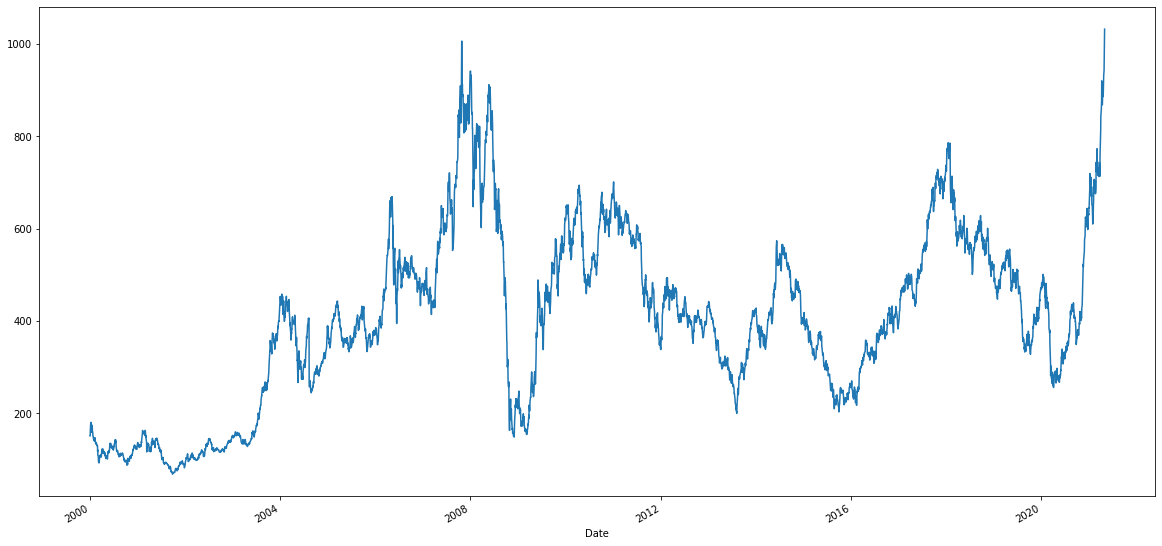

In [7]:
df['VWAP'].plot(figsize=FIG_SIZE)

In [10]:
cutoff = '2021-01-01'
train_ds, valid_ds = df.loc[df.index <= cutoff, ['VWAP']], df.loc[df.index > cutoff, ['VWAP']]
train_ds.shape, valid_ds.shape

((5227, 1), (79, 1))

In [12]:
model_lists.keys()

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best'])

In [13]:
model_lists['all']

['ConstantNaive',
 'LastValueNaive',
 'AverageValueNaive',
 'GLS',
 'GLM',
 'ETS',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'GluonTS',
 'SeasonalNaive',
 'UnobservedComponents',
 'VARMAX',
 'VECM',
 'DynamicFactor',
 'MotifSimulation',
 'WindowRegression',
 'VAR',
 'TFPRegression',
 'ComponentAnalysis',
 'DatepartRegression',
 'UnivariateRegression',
 'Greykite',
 'UnivariateMotif',
 'MultivariateMotif',
 'NVAR',
 'MultivariateRegression',
 'SectionalMotif',
 'Theta',
 'ARDL',
 'NeuralProphet',
 'DynamicFactorMQ']

In [14]:
model = AutoTS(forecast_length=valid_ds.shape[0], 
                ensemble='simple',
                model_list= ['GLM', 'Theta', 'ETS'], 
                transformer_list="superfast",  
                drop_most_recent=1,
                max_generations=5,
                num_validations=2,
                validation_method="backwards"
)

In [ ]:
model.fit(train_ds)

In [16]:
forecasts = model.predict()

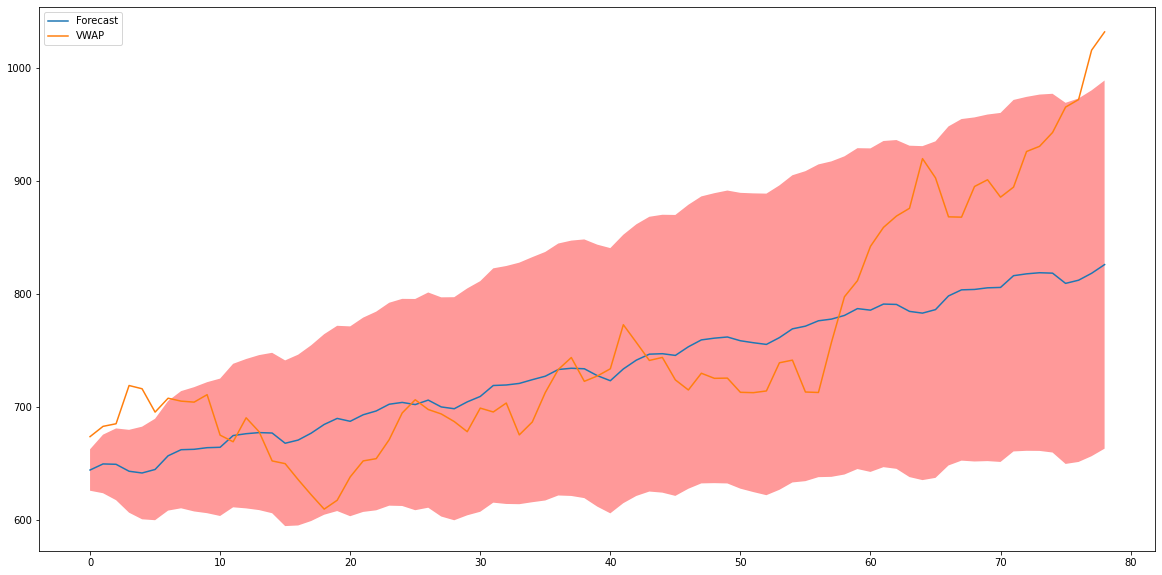

In [41]:
pd.concat([
            forecasts.forecast.rename(columns={'VWAP': 'Forecast'}).reset_index(drop=True),
            valid_ds.reset_index(drop=True)
          ], 
            axis=1).plot(figsize=(20, 10))
plt.fill_between(valid_ds.reset_index(drop=True).index,
                 forecasts.upper_forecast.rename(columns={'VWAP': 'Forecast Upper'}).reset_index(drop=True).squeeze(), 
                 forecasts.lower_forecast.rename(columns={'VWAP': 'Forecast Lower'}).reset_index(drop=True).squeeze()
                , facecolor='red', alpha=0.4)

In [50]:
np.sqrt(mean_squared_error(valid_ds, forecasts.forecast))

65.78852184798419

In [123]:
def eval_model(model,
               dataset,
               past_covariates=None,
               future_covariates=None,
               retrain=False,
               forecast_horizon=10,
               last_obs=100):
    back_test = model.historical_forecasts(series=dataset,
                                           past_covariates=past_covariates,
                                           future_covariates=future_covariates,
                                           start=0.8,
                                           retrain=retrain,
                                           verbose=True,
                                           forecast_horizon=forecast_horizon)
    
    
    dataset[-len(back_test) - last_obs:].plot()
    back_test.plot(label=f'backtest (n={forecast_horizon}))')
    
    print(f'Backtest RMSE = {rmse(dataset, back_test):.3f}')
    
    return back_test

In [98]:
series = TimeSeries.from_dataframe(df.loc[df.index > '2018-01-01', :].reset_index(), 'Date', 'VWAP', freq='D')
series = fill_missing_values(series)

In [99]:
train_ds, test_ds = series[:-60], series[-60:]

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 31.269


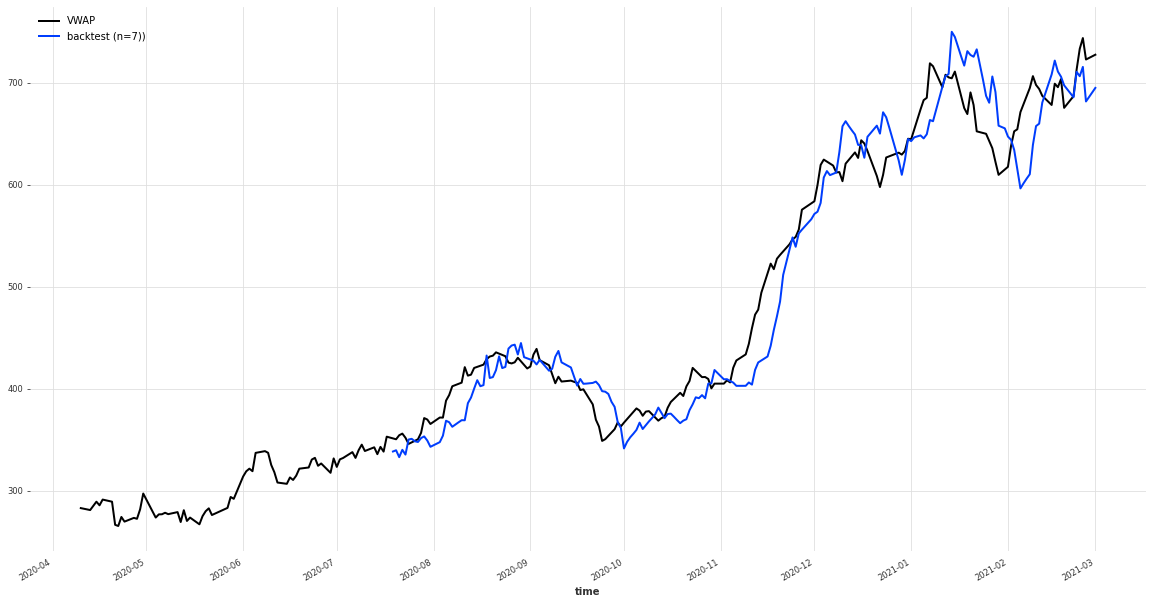

In [105]:
model = ExponentialSmoothing()
eval_model(model, train_ds, retrain=True, forecast_horizon=7)

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 30.912


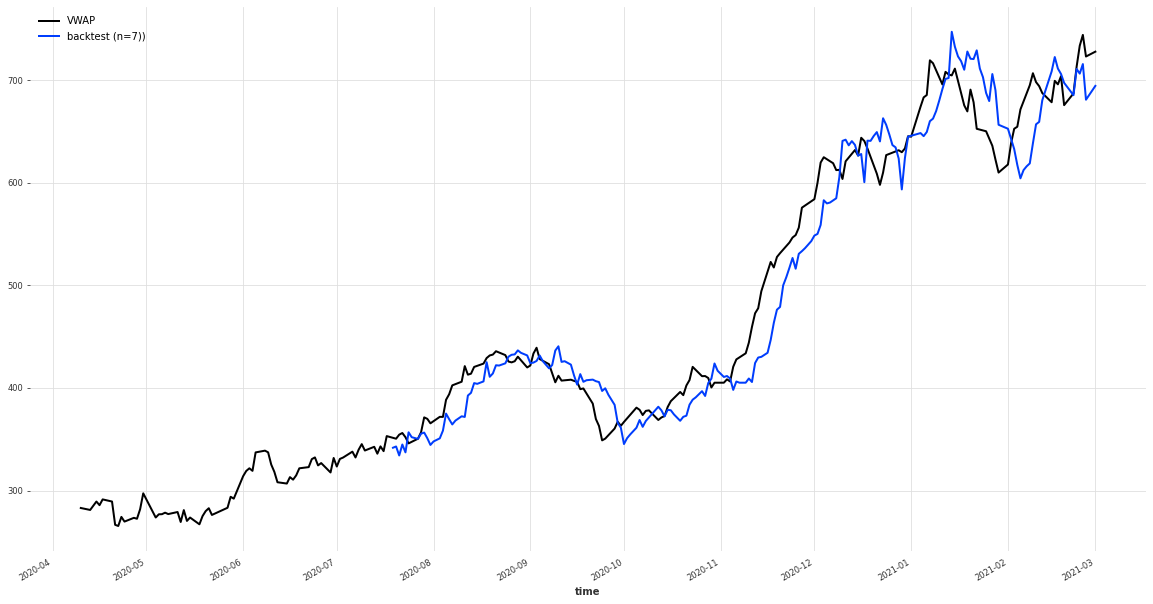

In [107]:
model = AutoARIMA()
eval_model(model, train_ds, retrain=True, forecast_horizon=7)

In [110]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train_ds)
val_transformed = transformer.transform(valid_ds)
series_transformed = transformer.transform(series)

In [111]:
model = RNNModel(model="GRU", hidden_dim=20, dropout=0, batch_size=16, n_epochs=10, optimizer_kwargs={"lr": 1e-3}, training_length=20, input_chunk_length=14, force_reset=True)

  0%|          | 0/223 [00:00<?, ?it/s]

[2022-06-19 16:55:40,347] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 903 samples.
[2022-06-19 16:55:40,347] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 903 samples.
2022-06-19 16:55:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 903 samples.
[2022-06-19 16:55:40,382] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-19 16:55:40,382] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-19 16:55:40 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-19 16:55:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:55:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:55:40 pytorch_li

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:55:52,247] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 904 samples.
[2022-06-19 16:55:52,247] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 904 samples.
2022-06-19 16:55:52 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 904 samples.
2022-06-19 16:55:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:55:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:55:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:55:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:55:52,253] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:01,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 905 samples.
[2022-06-19 16:56:01,924] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 905 samples.
2022-06-19 16:56:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 905 samples.
2022-06-19 16:56:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:01,932] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:11,635] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 906 samples.
[2022-06-19 16:56:11,635] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 906 samples.
2022-06-19 16:56:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 906 samples.
2022-06-19 16:56:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:11,641] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:21,690] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 907 samples.
[2022-06-19 16:56:21,690] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 907 samples.
2022-06-19 16:56:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 907 samples.
2022-06-19 16:56:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:21,698] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:31,320] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 908 samples.
[2022-06-19 16:56:31,320] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 908 samples.
2022-06-19 16:56:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 908 samples.
2022-06-19 16:56:31 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:31 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:31 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:31 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:31,326] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:40,653] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 909 samples.
[2022-06-19 16:56:40,653] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 909 samples.
2022-06-19 16:56:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 909 samples.
2022-06-19 16:56:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:40,661] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:50,203] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 910 samples.
[2022-06-19 16:56:50,203] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 910 samples.
2022-06-19 16:56:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 910 samples.
2022-06-19 16:56:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:50,210] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:56:59,727] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 911 samples.
[2022-06-19 16:56:59,727] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 911 samples.
2022-06-19 16:56:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 911 samples.
2022-06-19 16:56:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:56:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:56:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:56:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:56:59,736] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:57:09,161] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 912 samples.
[2022-06-19 16:57:09,161] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 912 samples.
2022-06-19 16:57:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 912 samples.
2022-06-19 16:57:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:09,166] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

[2022-06-19 16:57:18,839] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 913 samples.
[2022-06-19 16:57:18,839] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 913 samples.
2022-06-19 16:57:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 913 samples.
2022-06-19 16:57:18 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:18 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:18 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:18 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:18,845] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:57:28,501] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 914 samples.
[2022-06-19 16:57:28,501] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 914 samples.
2022-06-19 16:57:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 914 samples.
2022-06-19 16:57:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:28,508] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:57:38,288] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 915 samples.
[2022-06-19 16:57:38,288] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 915 samples.
2022-06-19 16:57:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 915 samples.
2022-06-19 16:57:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:38,294] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:57:48,277] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 916 samples.
[2022-06-19 16:57:48,277] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 916 samples.
2022-06-19 16:57:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 916 samples.
2022-06-19 16:57:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:48 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:48 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:48 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:48,283] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:57:58,297] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 917 samples.
[2022-06-19 16:57:58,297] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 917 samples.
2022-06-19 16:57:58 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 917 samples.
2022-06-19 16:57:58 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:57:58 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:57:58 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:57:58 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:57:58,305] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:08,302] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 918 samples.
[2022-06-19 16:58:08,302] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 918 samples.
2022-06-19 16:58:08 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 918 samples.
2022-06-19 16:58:08 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:08 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:08 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:08 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:08,310] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:18,323] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 919 samples.
[2022-06-19 16:58:18,323] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 919 samples.
2022-06-19 16:58:18 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 919 samples.
2022-06-19 16:58:18 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:18 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:18 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:18 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:18,328] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:27,218] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 920 samples.
[2022-06-19 16:58:27,218] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 920 samples.
2022-06-19 16:58:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 920 samples.
2022-06-19 16:58:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:27,224] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:36,193] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 921 samples.
[2022-06-19 16:58:36,193] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 921 samples.
2022-06-19 16:58:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 921 samples.
2022-06-19 16:58:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:36,198] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:45,156] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 922 samples.
[2022-06-19 16:58:45,156] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 922 samples.
2022-06-19 16:58:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 922 samples.
2022-06-19 16:58:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:45,166] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:58:54,020] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 923 samples.
[2022-06-19 16:58:54,020] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 923 samples.
2022-06-19 16:58:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 923 samples.
2022-06-19 16:58:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:58:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:58:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:58:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:58:54,025] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:03,006] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 924 samples.
[2022-06-19 16:59:03,006] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 924 samples.
2022-06-19 16:59:03 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 924 samples.
2022-06-19 16:59:03 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:03 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:03 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:03 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:03,011] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:11,975] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
[2022-06-19 16:59:11,975] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
2022-06-19 16:59:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 925 samples.
2022-06-19 16:59:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:11,980] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:20,918] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 926 samples.
[2022-06-19 16:59:20,918] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 926 samples.
2022-06-19 16:59:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 926 samples.
2022-06-19 16:59:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:20,923] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:29,873] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 927 samples.
[2022-06-19 16:59:29,873] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 927 samples.
2022-06-19 16:59:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 927 samples.
2022-06-19 16:59:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:29,879] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:38,874] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 928 samples.
[2022-06-19 16:59:38,874] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 928 samples.
2022-06-19 16:59:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 928 samples.
2022-06-19 16:59:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:38,880] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

[2022-06-19 16:59:47,967] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 929 samples.
[2022-06-19 16:59:47,967] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 929 samples.
2022-06-19 16:59:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 929 samples.
2022-06-19 16:59:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:47,973] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 16:59:57,122] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 930 samples.
[2022-06-19 16:59:57,122] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 930 samples.
2022-06-19 16:59:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 930 samples.
2022-06-19 16:59:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 16:59:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 16:59:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 16:59:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 16:59:57,128] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:06,268] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 931 samples.
[2022-06-19 17:00:06,268] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 931 samples.
2022-06-19 17:00:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 931 samples.
2022-06-19 17:00:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:06,275] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:15,443] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 932 samples.
[2022-06-19 17:00:15,443] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 932 samples.
2022-06-19 17:00:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 932 samples.
2022-06-19 17:00:15 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:15 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:15 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:15 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:15,449] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:24,487] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 933 samples.
[2022-06-19 17:00:24,487] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 933 samples.
2022-06-19 17:00:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 933 samples.
2022-06-19 17:00:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:24,493] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:33,659] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 934 samples.
[2022-06-19 17:00:33,659] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 934 samples.
2022-06-19 17:00:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 934 samples.
2022-06-19 17:00:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:33,665] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:42,705] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 935 samples.
[2022-06-19 17:00:42,705] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 935 samples.
2022-06-19 17:00:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 935 samples.
2022-06-19 17:00:42 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:42 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:42 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:42 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:42,710] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:00:51,974] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 936 samples.
[2022-06-19 17:00:51,974] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 936 samples.
2022-06-19 17:00:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 936 samples.
2022-06-19 17:00:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:00:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:00:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:00:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:00:51,980] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:01,063] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 937 samples.
[2022-06-19 17:01:01,063] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 937 samples.
2022-06-19 17:01:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 937 samples.
2022-06-19 17:01:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:01,068] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:10,428] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 938 samples.
[2022-06-19 17:01:10,428] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 938 samples.
2022-06-19 17:01:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 938 samples.
2022-06-19 17:01:10 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:10 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:10 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:10 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:10,437] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:19,602] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 939 samples.
[2022-06-19 17:01:19,602] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 939 samples.
2022-06-19 17:01:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 939 samples.
2022-06-19 17:01:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:19,608] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:28,704] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
[2022-06-19 17:01:28,704] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 940 samples.
2022-06-19 17:01:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 940 samples.
2022-06-19 17:01:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:28,711] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:37,744] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 941 samples.
[2022-06-19 17:01:37,744] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 941 samples.
2022-06-19 17:01:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 941 samples.
2022-06-19 17:01:37 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:37 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:37 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:37 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:37,750] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:47,043] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 942 samples.
[2022-06-19 17:01:47,043] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 942 samples.
2022-06-19 17:01:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 942 samples.
2022-06-19 17:01:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:47,051] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:01:56,223] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 943 samples.
[2022-06-19 17:01:56,223] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 943 samples.
2022-06-19 17:01:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 943 samples.
2022-06-19 17:01:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:01:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:01:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:01:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:01:56,229] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:02:05,372] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 944 samples.
[2022-06-19 17:02:05,372] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 944 samples.
2022-06-19 17:02:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 944 samples.
2022-06-19 17:02:05 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:05 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:05 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:05 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:05,378] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

[2022-06-19 17:02:14,712] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 945 samples.
[2022-06-19 17:02:14,712] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 945 samples.
2022-06-19 17:02:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 945 samples.
2022-06-19 17:02:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:14,719] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:02:24,092] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 946 samples.
[2022-06-19 17:02:24,092] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 946 samples.
2022-06-19 17:02:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 946 samples.
2022-06-19 17:02:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:24,100] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:02:33,756] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 947 samples.
[2022-06-19 17:02:33,756] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 947 samples.
2022-06-19 17:02:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 947 samples.
2022-06-19 17:02:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:33,765] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:02:43,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 948 samples.
[2022-06-19 17:02:43,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 948 samples.
2022-06-19 17:02:43 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 948 samples.
2022-06-19 17:02:43 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:43 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:43 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:43 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:43,196] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:02:54,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 949 samples.
[2022-06-19 17:02:54,693] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 949 samples.
2022-06-19 17:02:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 949 samples.
2022-06-19 17:02:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:02:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:02:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:02:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:02:54,702] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:04,785] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 950 samples.
[2022-06-19 17:03:04,785] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 950 samples.
2022-06-19 17:03:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 950 samples.
2022-06-19 17:03:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:04,792] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:14,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 951 samples.
[2022-06-19 17:03:14,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 951 samples.
2022-06-19 17:03:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 951 samples.
2022-06-19 17:03:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:14,450] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:24,267] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 952 samples.
[2022-06-19 17:03:24,267] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 952 samples.
2022-06-19 17:03:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 952 samples.
2022-06-19 17:03:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:24,273] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:34,393] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 953 samples.
[2022-06-19 17:03:34,393] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 953 samples.
2022-06-19 17:03:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 953 samples.
2022-06-19 17:03:34 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:34 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:34 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:34 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:34,398] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:44,646] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 954 samples.
[2022-06-19 17:03:44,646] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 954 samples.
2022-06-19 17:03:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 954 samples.
2022-06-19 17:03:44 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:44 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:44 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:44 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:44,652] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:03:54,886] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 955 samples.
[2022-06-19 17:03:54,886] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 955 samples.
2022-06-19 17:03:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 955 samples.
2022-06-19 17:03:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:03:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:03:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:03:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:03:54,893] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:04,765] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 956 samples.
[2022-06-19 17:04:04,765] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 956 samples.
2022-06-19 17:04:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 956 samples.
2022-06-19 17:04:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:04,771] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:14,382] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 957 samples.
[2022-06-19 17:04:14,382] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 957 samples.
2022-06-19 17:04:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 957 samples.
2022-06-19 17:04:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:14,388] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:24,270] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 958 samples.
[2022-06-19 17:04:24,270] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 958 samples.
2022-06-19 17:04:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 958 samples.
2022-06-19 17:04:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:24,279] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:34,530] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 959 samples.
[2022-06-19 17:04:34,530] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 959 samples.
2022-06-19 17:04:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 959 samples.
2022-06-19 17:04:34 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:34 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:34 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:34 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:34,537] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:44,245] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 960 samples.
[2022-06-19 17:04:44,245] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 960 samples.
2022-06-19 17:04:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 960 samples.
2022-06-19 17:04:44 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:44 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:44 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:44 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:44,250] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

[2022-06-19 17:04:54,827] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 961 samples.
[2022-06-19 17:04:54,827] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 961 samples.
2022-06-19 17:04:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 961 samples.
2022-06-19 17:04:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:04:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:04:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:04:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:04:54,840] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:05,344] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 962 samples.
[2022-06-19 17:05:05,344] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 962 samples.
2022-06-19 17:05:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 962 samples.
2022-06-19 17:05:05 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:05 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:05 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:05 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:05,349] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:16,132] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 963 samples.
[2022-06-19 17:05:16,132] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 963 samples.
2022-06-19 17:05:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 963 samples.
2022-06-19 17:05:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:16,140] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:25,891] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 964 samples.
[2022-06-19 17:05:25,891] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 964 samples.
2022-06-19 17:05:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 964 samples.
2022-06-19 17:05:25 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:25 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:25 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:25 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:25,897] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:35,814] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 965 samples.
[2022-06-19 17:05:35,814] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 965 samples.
2022-06-19 17:05:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 965 samples.
2022-06-19 17:05:35 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:35 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:35 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:35 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:35,823] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:45,808] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 966 samples.
[2022-06-19 17:05:45,808] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 966 samples.
2022-06-19 17:05:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 966 samples.
2022-06-19 17:05:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:45,817] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:05:55,571] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 967 samples.
[2022-06-19 17:05:55,571] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 967 samples.
2022-06-19 17:05:55 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 967 samples.
2022-06-19 17:05:55 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:05:55 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:05:55 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:05:55 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:05:55,576] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:05,366] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 968 samples.
[2022-06-19 17:06:05,366] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 968 samples.
2022-06-19 17:06:05 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 968 samples.
2022-06-19 17:06:05 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:05 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:05 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:05 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:05,373] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:15,138] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 969 samples.
[2022-06-19 17:06:15,138] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 969 samples.
2022-06-19 17:06:15 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 969 samples.
2022-06-19 17:06:15 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:15 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:15 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:15 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:15,143] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:25,286] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 970 samples.
[2022-06-19 17:06:25,286] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 970 samples.
2022-06-19 17:06:25 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 970 samples.
2022-06-19 17:06:25 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:25 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:25 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:25 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:25,292] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:35,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 971 samples.
[2022-06-19 17:06:35,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 971 samples.
2022-06-19 17:06:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 971 samples.
2022-06-19 17:06:35 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:35 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:35 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:35 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:35,042] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:44,696] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 972 samples.
[2022-06-19 17:06:44,696] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 972 samples.
2022-06-19 17:06:44 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 972 samples.
2022-06-19 17:06:44 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:44 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:44 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:44 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:44,705] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:06:54,830] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-06-19 17:06:54,830] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
2022-06-19 17:06:54 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 973 samples.
2022-06-19 17:06:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:06:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:06:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:06:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:06:54,837] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:07:04,855] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 974 samples.
[2022-06-19 17:07:04,855] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 974 samples.
2022-06-19 17:07:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 974 samples.
2022-06-19 17:07:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:04 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:04 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:04,864] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:07:14,405] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 975 samples.
[2022-06-19 17:07:14,405] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 975 samples.
2022-06-19 17:07:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 975 samples.
2022-06-19 17:07:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:14,413] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:07:24,045] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 976 samples.
[2022-06-19 17:07:24,045] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 976 samples.
2022-06-19 17:07:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 976 samples.
2022-06-19 17:07:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:24,050] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

[2022-06-19 17:07:33,662] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 977 samples.
[2022-06-19 17:07:33,662] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 977 samples.
2022-06-19 17:07:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 977 samples.
2022-06-19 17:07:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:33,669] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:07:43,367] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 978 samples.
[2022-06-19 17:07:43,367] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 978 samples.
2022-06-19 17:07:43 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 978 samples.
2022-06-19 17:07:43 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:43 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:43 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:43 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:43,374] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:07:53,164] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 979 samples.
[2022-06-19 17:07:53,164] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 979 samples.
2022-06-19 17:07:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 979 samples.
2022-06-19 17:07:53 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:07:53 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:07:53 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:07:53 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:07:53,169] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:02,935] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 980 samples.
[2022-06-19 17:08:02,935] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 980 samples.
2022-06-19 17:08:02 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 980 samples.
2022-06-19 17:08:02 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:02 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:02 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:02 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:02,941] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:12,672] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 981 samples.
[2022-06-19 17:08:12,672] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 981 samples.
2022-06-19 17:08:12 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 981 samples.
2022-06-19 17:08:12 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:12 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:12 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:12 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:12,678] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:22,402] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 982 samples.
[2022-06-19 17:08:22,402] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 982 samples.
2022-06-19 17:08:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 982 samples.
2022-06-19 17:08:22 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:22 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:22 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:22 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:22,409] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:32,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 983 samples.
[2022-06-19 17:08:32,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 983 samples.
2022-06-19 17:08:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 983 samples.
2022-06-19 17:08:32 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:32 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:32 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:32 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:32,237] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:41,858] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 984 samples.
[2022-06-19 17:08:41,858] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 984 samples.
2022-06-19 17:08:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 984 samples.
2022-06-19 17:08:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:41,865] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:08:51,522] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 985 samples.
[2022-06-19 17:08:51,522] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 985 samples.
2022-06-19 17:08:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 985 samples.
2022-06-19 17:08:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:08:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:08:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:08:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:08:51,527] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:01,200] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 986 samples.
[2022-06-19 17:09:01,200] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 986 samples.
2022-06-19 17:09:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 986 samples.
2022-06-19 17:09:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:01,208] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:10,934] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 987 samples.
[2022-06-19 17:09:10,934] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 987 samples.
2022-06-19 17:09:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 987 samples.
2022-06-19 17:09:10 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:10 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:10 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:10 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:10,939] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:20,779] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 988 samples.
[2022-06-19 17:09:20,779] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 988 samples.
2022-06-19 17:09:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 988 samples.
2022-06-19 17:09:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:20,785] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:30,537] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 989 samples.
[2022-06-19 17:09:30,537] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 989 samples.
2022-06-19 17:09:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 989 samples.
2022-06-19 17:09:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:30,543] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:40,388] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 990 samples.
[2022-06-19 17:09:40,388] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 990 samples.
2022-06-19 17:09:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 990 samples.
2022-06-19 17:09:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:40,395] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:49,950] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 991 samples.
[2022-06-19 17:09:49,950] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 991 samples.
2022-06-19 17:09:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 991 samples.
2022-06-19 17:09:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:49,955] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:09:59,821] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 992 samples.
[2022-06-19 17:09:59,821] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 992 samples.
2022-06-19 17:09:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 992 samples.
2022-06-19 17:09:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:09:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:09:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:09:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:09:59,827] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

[2022-06-19 17:10:09,770] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 993 samples.
[2022-06-19 17:10:09,770] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 993 samples.
2022-06-19 17:10:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 993 samples.
2022-06-19 17:10:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:09,778] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:10:19,701] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 994 samples.
[2022-06-19 17:10:19,701] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 994 samples.
2022-06-19 17:10:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 994 samples.
2022-06-19 17:10:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:19,709] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:10:29,588] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 995 samples.
[2022-06-19 17:10:29,588] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 995 samples.
2022-06-19 17:10:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 995 samples.
2022-06-19 17:10:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:29,594] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:10:39,676] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 996 samples.
[2022-06-19 17:10:39,676] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 996 samples.
2022-06-19 17:10:39 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 996 samples.
2022-06-19 17:10:39 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:39 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:39 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:39 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:39,684] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:10:49,763] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 997 samples.
[2022-06-19 17:10:49,763] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 997 samples.
2022-06-19 17:10:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 997 samples.
2022-06-19 17:10:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:49,769] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:10:59,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 998 samples.
[2022-06-19 17:10:59,600] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 998 samples.
2022-06-19 17:10:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 998 samples.
2022-06-19 17:10:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:10:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:10:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:10:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:10:59,605] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:11:09,661] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 999 samples.
[2022-06-19 17:11:09,661] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 999 samples.
2022-06-19 17:11:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 999 samples.
2022-06-19 17:11:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:11:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:11:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:11:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:11:09,667] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying 

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:11:19,721] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1000 samples.
[2022-06-19 17:11:19,721] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1000 samples.
2022-06-19 17:11:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1000 samples.
2022-06-19 17:11:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:11:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:11:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:11:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:11:19,728] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:11:29,938] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1001 samples.
[2022-06-19 17:11:29,938] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1001 samples.
2022-06-19 17:11:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1001 samples.
2022-06-19 17:11:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:11:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:11:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:11:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:11:29,947] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:11:40,067] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1002 samples.
[2022-06-19 17:11:40,067] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1002 samples.
2022-06-19 17:11:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1002 samples.
2022-06-19 17:11:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:11:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:11:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:11:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:11:40,074] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:11:50,312] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1003 samples.
[2022-06-19 17:11:50,312] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1003 samples.
2022-06-19 17:11:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1003 samples.
2022-06-19 17:11:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:11:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:11:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:11:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:11:50,319] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:00,446] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1004 samples.
[2022-06-19 17:12:00,446] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1004 samples.
2022-06-19 17:12:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1004 samples.
2022-06-19 17:12:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:00,452] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:10,692] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1005 samples.
[2022-06-19 17:12:10,692] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1005 samples.
2022-06-19 17:12:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1005 samples.
2022-06-19 17:12:10 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:10 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:10 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:10 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:10,698] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:20,641] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1006 samples.
[2022-06-19 17:12:20,641] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1006 samples.
2022-06-19 17:12:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1006 samples.
2022-06-19 17:12:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:20,646] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:30,532] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1007 samples.
[2022-06-19 17:12:30,532] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1007 samples.
2022-06-19 17:12:30 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1007 samples.
2022-06-19 17:12:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:30,538] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:40,412] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1008 samples.
[2022-06-19 17:12:40,412] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1008 samples.
2022-06-19 17:12:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1008 samples.
2022-06-19 17:12:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:40,418] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

[2022-06-19 17:12:50,474] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1009 samples.
[2022-06-19 17:12:50,474] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1009 samples.
2022-06-19 17:12:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1009 samples.
2022-06-19 17:12:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:12:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:12:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:12:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:12:50,481] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:00,833] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1010 samples.
[2022-06-19 17:13:00,833] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1010 samples.
2022-06-19 17:13:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1010 samples.
2022-06-19 17:13:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:00,839] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:10,993] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1011 samples.
[2022-06-19 17:13:10,993] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1011 samples.
2022-06-19 17:13:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1011 samples.
2022-06-19 17:13:10 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:10 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:10 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:11,000] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:21,021] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1012 samples.
[2022-06-19 17:13:21,021] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1012 samples.
2022-06-19 17:13:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1012 samples.
2022-06-19 17:13:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:21,027] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:31,253] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1013 samples.
[2022-06-19 17:13:31,253] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1013 samples.
2022-06-19 17:13:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1013 samples.
2022-06-19 17:13:31 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:31 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:31 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:31 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:31,262] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:41,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1014 samples.
[2022-06-19 17:13:41,424] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1014 samples.
2022-06-19 17:13:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1014 samples.
2022-06-19 17:13:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:41,430] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:13:51,577] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1015 samples.
[2022-06-19 17:13:51,577] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1015 samples.
2022-06-19 17:13:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1015 samples.
2022-06-19 17:13:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:13:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:13:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:13:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:13:51,584] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:01,598] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1016 samples.
[2022-06-19 17:14:01,598] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1016 samples.
2022-06-19 17:14:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1016 samples.
2022-06-19 17:14:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:01,604] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:11,534] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1017 samples.
[2022-06-19 17:14:11,534] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1017 samples.
2022-06-19 17:14:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1017 samples.
2022-06-19 17:14:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:11,540] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:21,535] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1018 samples.
[2022-06-19 17:14:21,535] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1018 samples.
2022-06-19 17:14:21 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1018 samples.
2022-06-19 17:14:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:21,543] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:31,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1019 samples.
[2022-06-19 17:14:31,444] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1019 samples.
2022-06-19 17:14:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1019 samples.
2022-06-19 17:14:31 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:31 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:31 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:31 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:31,450] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:41,137] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1020 samples.
[2022-06-19 17:14:41,137] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1020 samples.
2022-06-19 17:14:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1020 samples.
2022-06-19 17:14:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:41,143] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:14:50,678] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1021 samples.
[2022-06-19 17:14:50,678] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1021 samples.
2022-06-19 17:14:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1021 samples.
2022-06-19 17:14:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:14:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:14:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:14:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:14:50,685] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:15:00,138] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1022 samples.
[2022-06-19 17:15:00,138] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1022 samples.
2022-06-19 17:15:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1022 samples.
2022-06-19 17:15:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:00,143] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:15:09,460] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1023 samples.
[2022-06-19 17:15:09,460] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1023 samples.
2022-06-19 17:15:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1023 samples.
2022-06-19 17:15:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:09,466] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:15:19,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1024 samples.
[2022-06-19 17:15:19,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1024 samples.
2022-06-19 17:15:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1024 samples.
2022-06-19 17:15:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:19,074] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

[2022-06-19 17:15:28,732] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1025 samples.
[2022-06-19 17:15:28,732] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1025 samples.
2022-06-19 17:15:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1025 samples.
2022-06-19 17:15:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:28,739] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:15:38,408] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1026 samples.
[2022-06-19 17:15:38,408] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1026 samples.
2022-06-19 17:15:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1026 samples.
2022-06-19 17:15:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:38,417] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:15:48,239] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1027 samples.
[2022-06-19 17:15:48,239] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1027 samples.
2022-06-19 17:15:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1027 samples.
2022-06-19 17:15:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:48 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:48 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:48 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:48,244] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:15:57,960] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1028 samples.
[2022-06-19 17:15:57,960] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1028 samples.
2022-06-19 17:15:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1028 samples.
2022-06-19 17:15:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:15:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:15:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:15:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:15:57,968] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:07,588] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1029 samples.
[2022-06-19 17:16:07,588] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1029 samples.
2022-06-19 17:16:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1029 samples.
2022-06-19 17:16:07 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:07 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:07 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:07 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:07,594] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:17,585] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1030 samples.
[2022-06-19 17:16:17,585] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1030 samples.
2022-06-19 17:16:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1030 samples.
2022-06-19 17:16:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:17,593] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:27,357] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1031 samples.
[2022-06-19 17:16:27,357] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1031 samples.
2022-06-19 17:16:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1031 samples.
2022-06-19 17:16:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:27,363] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:37,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1032 samples.
[2022-06-19 17:16:37,272] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1032 samples.
2022-06-19 17:16:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1032 samples.
2022-06-19 17:16:37 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:37 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:37 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:37 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:37,278] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:47,214] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1033 samples.
[2022-06-19 17:16:47,214] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1033 samples.
2022-06-19 17:16:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1033 samples.
2022-06-19 17:16:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:47,220] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:16:57,098] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1034 samples.
[2022-06-19 17:16:57,098] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1034 samples.
2022-06-19 17:16:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1034 samples.
2022-06-19 17:16:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:16:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:16:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:16:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:16:57,103] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:06,974] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1035 samples.
[2022-06-19 17:17:06,974] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1035 samples.
2022-06-19 17:17:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1035 samples.
2022-06-19 17:17:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:06,980] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:16,756] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1036 samples.
[2022-06-19 17:17:16,756] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1036 samples.
2022-06-19 17:17:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1036 samples.
2022-06-19 17:17:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:16,761] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:26,644] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1037 samples.
[2022-06-19 17:17:26,644] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1037 samples.
2022-06-19 17:17:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1037 samples.
2022-06-19 17:17:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:26,650] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:36,410] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1038 samples.
[2022-06-19 17:17:36,410] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1038 samples.
2022-06-19 17:17:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1038 samples.
2022-06-19 17:17:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:36,416] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:46,311] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1039 samples.
[2022-06-19 17:17:46,311] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1039 samples.
2022-06-19 17:17:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1039 samples.
2022-06-19 17:17:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:46,316] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:17:56,247] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1040 samples.
[2022-06-19 17:17:56,247] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1040 samples.
2022-06-19 17:17:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1040 samples.
2022-06-19 17:17:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:17:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:17:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:17:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:17:56,253] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

[2022-06-19 17:18:06,170] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1041 samples.
[2022-06-19 17:18:06,170] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1041 samples.
2022-06-19 17:18:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1041 samples.
2022-06-19 17:18:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:06,176] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:18:16,014] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1042 samples.
[2022-06-19 17:18:16,014] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1042 samples.
2022-06-19 17:18:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1042 samples.
2022-06-19 17:18:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:16,020] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:18:26,081] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1043 samples.
[2022-06-19 17:18:26,081] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1043 samples.
2022-06-19 17:18:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1043 samples.
2022-06-19 17:18:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:26,086] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:18:36,178] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1044 samples.
[2022-06-19 17:18:36,178] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1044 samples.
2022-06-19 17:18:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1044 samples.
2022-06-19 17:18:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:36,184] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:18:46,267] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1045 samples.
[2022-06-19 17:18:46,267] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1045 samples.
2022-06-19 17:18:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1045 samples.
2022-06-19 17:18:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:46,272] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:18:56,264] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1046 samples.
[2022-06-19 17:18:56,264] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1046 samples.
2022-06-19 17:18:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1046 samples.
2022-06-19 17:18:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:18:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:18:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:18:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:18:56,269] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:06,306] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1047 samples.
[2022-06-19 17:19:06,306] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1047 samples.
2022-06-19 17:19:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1047 samples.
2022-06-19 17:19:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:06,312] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:16,395] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1048 samples.
[2022-06-19 17:19:16,395] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1048 samples.
2022-06-19 17:19:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1048 samples.
2022-06-19 17:19:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:16,401] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:26,358] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1049 samples.
[2022-06-19 17:19:26,358] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1049 samples.
2022-06-19 17:19:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1049 samples.
2022-06-19 17:19:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:26,366] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:36,310] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1050 samples.
[2022-06-19 17:19:36,310] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1050 samples.
2022-06-19 17:19:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1050 samples.
2022-06-19 17:19:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:36,316] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:46,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1051 samples.
[2022-06-19 17:19:46,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1051 samples.
2022-06-19 17:19:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1051 samples.
2022-06-19 17:19:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:46,389] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:19:56,294] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1052 samples.
[2022-06-19 17:19:56,294] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1052 samples.
2022-06-19 17:19:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1052 samples.
2022-06-19 17:19:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:19:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:19:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:19:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:19:56,302] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:20:06,328] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1053 samples.
[2022-06-19 17:20:06,328] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1053 samples.
2022-06-19 17:20:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1053 samples.
2022-06-19 17:20:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:06,333] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:20:16,281] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1054 samples.
[2022-06-19 17:20:16,281] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1054 samples.
2022-06-19 17:20:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1054 samples.
2022-06-19 17:20:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:16,288] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:20:26,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1055 samples.
[2022-06-19 17:20:26,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1055 samples.
2022-06-19 17:20:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1055 samples.
2022-06-19 17:20:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:26,309] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:20:36,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1056 samples.
[2022-06-19 17:20:36,536] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1056 samples.
2022-06-19 17:20:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1056 samples.
2022-06-19 17:20:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:36,548] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

[2022-06-19 17:20:46,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1057 samples.
[2022-06-19 17:20:46,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1057 samples.
2022-06-19 17:20:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1057 samples.
2022-06-19 17:20:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:46,467] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:20:56,465] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1058 samples.
[2022-06-19 17:20:56,465] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1058 samples.
2022-06-19 17:20:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1058 samples.
2022-06-19 17:20:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:20:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:20:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:20:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:20:56,472] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:06,318] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1059 samples.
[2022-06-19 17:21:06,318] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1059 samples.
2022-06-19 17:21:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1059 samples.
2022-06-19 17:21:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:06,325] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:16,252] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1060 samples.
[2022-06-19 17:21:16,252] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1060 samples.
2022-06-19 17:21:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1060 samples.
2022-06-19 17:21:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:16,258] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:26,053] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1061 samples.
[2022-06-19 17:21:26,053] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1061 samples.
2022-06-19 17:21:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1061 samples.
2022-06-19 17:21:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:26,059] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:36,110] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1062 samples.
[2022-06-19 17:21:36,110] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1062 samples.
2022-06-19 17:21:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1062 samples.
2022-06-19 17:21:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:36,116] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:46,121] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1063 samples.
[2022-06-19 17:21:46,121] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1063 samples.
2022-06-19 17:21:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1063 samples.
2022-06-19 17:21:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:46,127] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:21:56,227] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1064 samples.
[2022-06-19 17:21:56,227] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1064 samples.
2022-06-19 17:21:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1064 samples.
2022-06-19 17:21:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:21:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:21:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:21:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:21:56,233] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:06,188] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1065 samples.
[2022-06-19 17:22:06,188] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1065 samples.
2022-06-19 17:22:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1065 samples.
2022-06-19 17:22:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:06,194] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:16,196] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1066 samples.
[2022-06-19 17:22:16,196] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1066 samples.
2022-06-19 17:22:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1066 samples.
2022-06-19 17:22:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:16,202] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:26,336] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1067 samples.
[2022-06-19 17:22:26,336] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1067 samples.
2022-06-19 17:22:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1067 samples.
2022-06-19 17:22:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:26,343] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:36,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1068 samples.
[2022-06-19 17:22:36,572] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1068 samples.
2022-06-19 17:22:36 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1068 samples.
2022-06-19 17:22:36 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:36 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:36 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:36 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:36,577] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:46,630] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1069 samples.
[2022-06-19 17:22:46,630] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1069 samples.
2022-06-19 17:22:46 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1069 samples.
2022-06-19 17:22:46 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:46 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:46 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:46 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:46,636] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:22:56,757] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1070 samples.
[2022-06-19 17:22:56,757] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1070 samples.
2022-06-19 17:22:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1070 samples.
2022-06-19 17:22:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:22:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:22:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:22:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:22:56,763] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:23:06,810] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1071 samples.
[2022-06-19 17:23:06,810] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1071 samples.
2022-06-19 17:23:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1071 samples.
2022-06-19 17:23:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:06,817] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:23:16,990] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1072 samples.
[2022-06-19 17:23:16,990] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1072 samples.
2022-06-19 17:23:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1072 samples.
2022-06-19 17:23:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:16,998] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

[2022-06-19 17:23:26,946] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1073 samples.
[2022-06-19 17:23:26,946] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1073 samples.
2022-06-19 17:23:26 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1073 samples.
2022-06-19 17:23:26 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:26 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:26 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:26 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:26,952] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:23:37,141] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1074 samples.
[2022-06-19 17:23:37,141] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1074 samples.
2022-06-19 17:23:37 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1074 samples.
2022-06-19 17:23:37 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:37 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:37 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:37 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:37,148] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:23:47,398] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1075 samples.
[2022-06-19 17:23:47,398] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1075 samples.
2022-06-19 17:23:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1075 samples.
2022-06-19 17:23:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:47,403] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:23:57,549] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1076 samples.
[2022-06-19 17:23:57,549] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1076 samples.
2022-06-19 17:23:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1076 samples.
2022-06-19 17:23:57 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:23:57 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:23:57 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:23:57 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:23:57,555] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:07,831] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1077 samples.
[2022-06-19 17:24:07,831] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1077 samples.
2022-06-19 17:24:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1077 samples.
2022-06-19 17:24:07 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:07 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:07 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:07 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:07,836] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:17,998] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1078 samples.
[2022-06-19 17:24:17,998] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1078 samples.
2022-06-19 17:24:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1078 samples.
2022-06-19 17:24:18 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:18 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:18 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:18 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:18,004] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:28,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1079 samples.
[2022-06-19 17:24:28,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1079 samples.
2022-06-19 17:24:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1079 samples.
2022-06-19 17:24:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:28,390] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:38,464] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1080 samples.
[2022-06-19 17:24:38,464] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1080 samples.
2022-06-19 17:24:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1080 samples.
2022-06-19 17:24:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:38,474] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:48,535] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1081 samples.
[2022-06-19 17:24:48,535] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1081 samples.
2022-06-19 17:24:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1081 samples.
2022-06-19 17:24:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:48 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:48 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:48 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:48,541] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:24:58,683] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1082 samples.
[2022-06-19 17:24:58,683] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1082 samples.
2022-06-19 17:24:58 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1082 samples.
2022-06-19 17:24:58 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:24:58 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:24:58 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:24:58 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:24:58,688] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:25:09,068] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1083 samples.
[2022-06-19 17:25:09,068] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1083 samples.
2022-06-19 17:25:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1083 samples.
2022-06-19 17:25:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:25:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:25:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:25:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:25:09,075] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:25:19,414] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1084 samples.
[2022-06-19 17:25:19,414] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1084 samples.
2022-06-19 17:25:19 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1084 samples.
2022-06-19 17:25:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:25:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:25:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:25:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:25:19,422] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:25:29,745] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1085 samples.
[2022-06-19 17:25:29,745] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1085 samples.
2022-06-19 17:25:29 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1085 samples.
2022-06-19 17:25:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:25:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:25:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:25:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:25:29,753] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:25:40,101] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1086 samples.
[2022-06-19 17:25:40,101] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1086 samples.
2022-06-19 17:25:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1086 samples.
2022-06-19 17:25:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:25:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:25:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:25:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:25:40,106] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:25:50,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1087 samples.
[2022-06-19 17:25:50,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1087 samples.
2022-06-19 17:25:50 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1087 samples.
2022-06-19 17:25:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:25:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:25:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:25:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:25:50,519] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:26:00,834] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
[2022-06-19 17:26:00,834] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
2022-06-19 17:26:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1088 samples.
2022-06-19 17:26:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:00 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:00 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:00,840] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

[2022-06-19 17:26:11,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1089 samples.
[2022-06-19 17:26:11,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1089 samples.
2022-06-19 17:26:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1089 samples.
2022-06-19 17:26:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:11,208] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:26:22,139] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1090 samples.
[2022-06-19 17:26:22,139] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1090 samples.
2022-06-19 17:26:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1090 samples.
2022-06-19 17:26:22 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:22 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:22 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:22 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:22,144] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:26:32,544] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1091 samples.
[2022-06-19 17:26:32,544] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1091 samples.
2022-06-19 17:26:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1091 samples.
2022-06-19 17:26:32 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:32 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:32 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:32 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:32,550] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:26:42,914] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1092 samples.
[2022-06-19 17:26:42,914] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1092 samples.
2022-06-19 17:26:42 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1092 samples.
2022-06-19 17:26:42 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:42 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:42 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:42 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:42,921] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:26:53,514] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1093 samples.
[2022-06-19 17:26:53,514] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1093 samples.
2022-06-19 17:26:53 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1093 samples.
2022-06-19 17:26:53 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:26:53 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:26:53 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:26:53 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:26:53,520] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:03,927] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1094 samples.
[2022-06-19 17:27:03,927] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1094 samples.
2022-06-19 17:27:03 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1094 samples.
2022-06-19 17:27:03 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:03 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:03 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:03 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:03,933] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:14,340] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1095 samples.
[2022-06-19 17:27:14,340] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1095 samples.
2022-06-19 17:27:14 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1095 samples.
2022-06-19 17:27:14 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:14 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:14 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:14 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:14,348] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:24,953] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
[2022-06-19 17:27:24,953] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1096 samples.
2022-06-19 17:27:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1096 samples.
2022-06-19 17:27:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:24,960] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:35,476] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1097 samples.
[2022-06-19 17:27:35,476] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1097 samples.
2022-06-19 17:27:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1097 samples.
2022-06-19 17:27:35 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:35 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:35 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:35 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:35,482] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:45,922] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1098 samples.
[2022-06-19 17:27:45,922] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1098 samples.
2022-06-19 17:27:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1098 samples.
2022-06-19 17:27:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:45,927] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:27:56,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1099 samples.
[2022-06-19 17:27:56,461] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1099 samples.
2022-06-19 17:27:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1099 samples.
2022-06-19 17:27:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:27:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:27:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:27:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:27:56,469] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:07,066] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1100 samples.
[2022-06-19 17:28:07,066] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1100 samples.
2022-06-19 17:28:07 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1100 samples.
2022-06-19 17:28:07 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:07 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:07 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:07 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:07,072] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:17,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1101 samples.
[2022-06-19 17:28:17,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1101 samples.
2022-06-19 17:28:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1101 samples.
2022-06-19 17:28:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:17,658] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:27,913] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1102 samples.
[2022-06-19 17:28:27,913] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1102 samples.
2022-06-19 17:28:27 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1102 samples.
2022-06-19 17:28:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:27,919] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:38,143] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1103 samples.
[2022-06-19 17:28:38,143] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1103 samples.
2022-06-19 17:28:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1103 samples.
2022-06-19 17:28:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:38,151] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:48,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1104 samples.
[2022-06-19 17:28:48,545] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1104 samples.
2022-06-19 17:28:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1104 samples.
2022-06-19 17:28:48 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:48 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:48 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:48 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:48,551] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

[2022-06-19 17:28:59,173] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1105 samples.
[2022-06-19 17:28:59,173] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1105 samples.
2022-06-19 17:28:59 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1105 samples.
2022-06-19 17:28:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:28:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:28:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:28:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:28:59,178] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:29:09,803] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1106 samples.
[2022-06-19 17:29:09,803] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1106 samples.
2022-06-19 17:29:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1106 samples.
2022-06-19 17:29:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:29:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:29:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:29:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:29:09,809] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:29:20,509] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1107 samples.
[2022-06-19 17:29:20,509] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1107 samples.
2022-06-19 17:29:20 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1107 samples.
2022-06-19 17:29:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:29:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:29:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:29:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:29:20,516] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:29:31,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1108 samples.
[2022-06-19 17:29:31,036] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1108 samples.
2022-06-19 17:29:31 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1108 samples.
2022-06-19 17:29:31 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:29:31 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:29:31 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:29:31 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:29:31,044] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:29:41,655] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1109 samples.
[2022-06-19 17:29:41,655] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1109 samples.
2022-06-19 17:29:41 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1109 samples.
2022-06-19 17:29:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:29:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:29:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:29:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:29:41,660] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:29:52,273] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1110 samples.
[2022-06-19 17:29:52,273] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1110 samples.
2022-06-19 17:29:52 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1110 samples.
2022-06-19 17:29:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:29:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:29:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:29:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:29:52,278] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:02,912] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1111 samples.
[2022-06-19 17:30:02,912] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1111 samples.
2022-06-19 17:30:02 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1111 samples.
2022-06-19 17:30:02 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:02 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:02 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:02 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:02,918] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:13,577] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1112 samples.
[2022-06-19 17:30:13,577] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1112 samples.
2022-06-19 17:30:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1112 samples.
2022-06-19 17:30:13 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:13 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:13 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:13 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:13,584] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:24,236] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1113 samples.
[2022-06-19 17:30:24,236] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1113 samples.
2022-06-19 17:30:24 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1113 samples.
2022-06-19 17:30:24 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:24 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:24 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:24 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:24,242] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:34,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1114 samples.
[2022-06-19 17:30:34,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1114 samples.
2022-06-19 17:30:34 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1114 samples.
2022-06-19 17:30:34 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:34 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:34 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:34 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:34,873] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:45,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1115 samples.
[2022-06-19 17:30:45,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1115 samples.
2022-06-19 17:30:45 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1115 samples.
2022-06-19 17:30:45 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:45 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:45 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:45 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:45,517] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:30:56,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1116 samples.
[2022-06-19 17:30:56,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1116 samples.
2022-06-19 17:30:56 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1116 samples.
2022-06-19 17:30:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:30:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:30:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:30:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:30:56,208] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:31:06,880] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1117 samples.
[2022-06-19 17:31:06,880] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1117 samples.
2022-06-19 17:31:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1117 samples.
2022-06-19 17:31:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:31:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:31:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:31:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:31:06,886] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:31:17,480] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1118 samples.
[2022-06-19 17:31:17,480] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1118 samples.
2022-06-19 17:31:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1118 samples.
2022-06-19 17:31:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:31:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:31:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:31:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:31:17,487] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:31:28,216] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1119 samples.
[2022-06-19 17:31:28,216] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1119 samples.
2022-06-19 17:31:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1119 samples.
2022-06-19 17:31:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:31:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:31:28 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:31:28 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:31:28,221] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:31:38,898] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1120 samples.
[2022-06-19 17:31:38,898] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1120 samples.
2022-06-19 17:31:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1120 samples.
2022-06-19 17:31:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:31:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:31:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:31:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:31:38,906] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

[2022-06-19 17:31:49,575] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1121 samples.
[2022-06-19 17:31:49,575] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1121 samples.
2022-06-19 17:31:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1121 samples.
2022-06-19 17:31:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:31:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:31:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:31:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:31:49,581] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

[2022-06-19 17:32:00,380] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1122 samples.
[2022-06-19 17:32:00,380] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1122 samples.
2022-06-19 17:32:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1122 samples.
2022-06-19 17:32:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:32:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:32:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:32:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:32:01,072] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

[2022-06-19 17:32:11,979] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1123 samples.
[2022-06-19 17:32:11,979] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1123 samples.
2022-06-19 17:32:11 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1123 samples.
2022-06-19 17:32:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:32:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:32:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:32:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:32:11,985] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

[2022-06-19 17:32:22,836] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1124 samples.
[2022-06-19 17:32:22,836] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1124 samples.
2022-06-19 17:32:22 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1124 samples.
2022-06-19 17:32:22 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:32:22 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:32:22 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:32:22 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:32:22,844] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

[2022-06-19 17:32:33,718] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1125 samples.
[2022-06-19 17:32:33,718] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1125 samples.
2022-06-19 17:32:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1125 samples.
2022-06-19 17:32:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-19 17:32:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-19 17:32:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-19 17:32:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
[2022-06-19 17:32:33,726] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifyi

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Backtest RMSE = 0.095


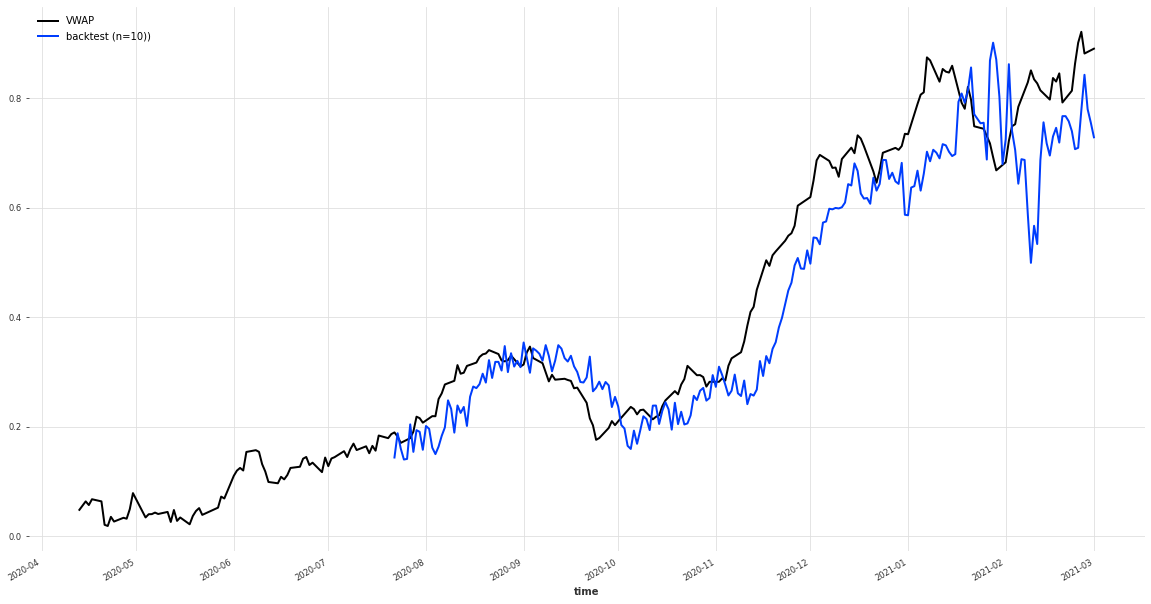

In [120]:
eval_model(model, train_transformed, retrain=True)

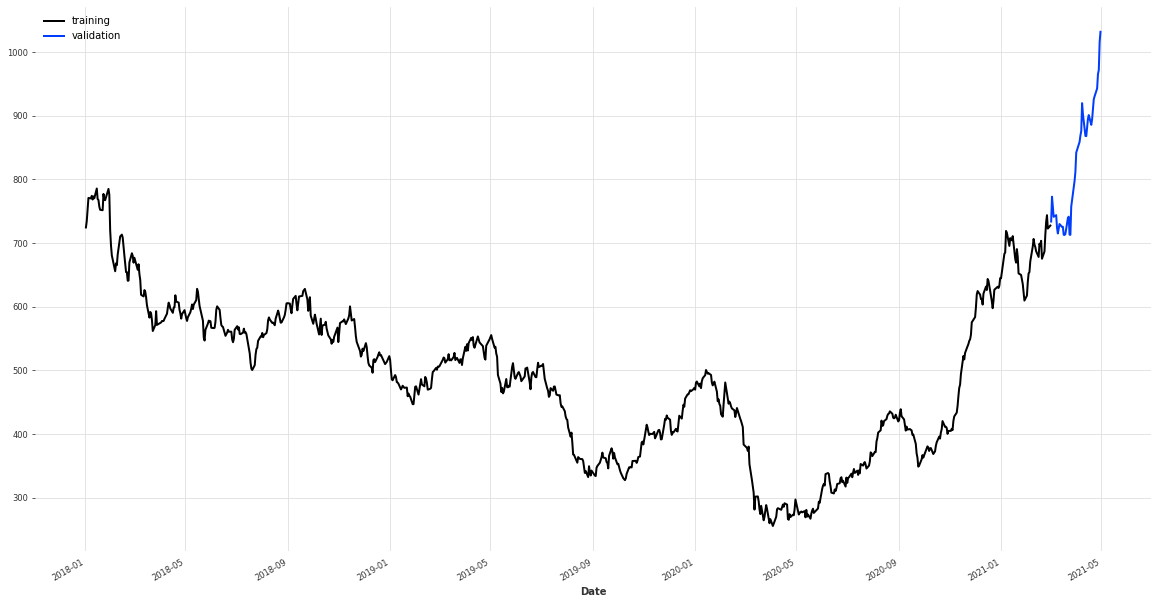

In [122]:
train_ds.plot(label='training')
valid_ds.plot(label='validation')

In [125]:
models = [ExponentialSmoothing(), NaiveMean(), Theta(), AutoARIMA()]

  0%|          | 0/223 [00:00<?, ?it/s]

Backtest RMSE = 41.327


  0%|          | 0/223 [00:00<?, ?it/s]

Backtest RMSE = 133.397


  0%|          | 0/223 [00:00<?, ?it/s]

Backtest RMSE = 54.418


  0%|          | 0/223 [00:00<?, ?it/s]

Backtest RMSE = 40.291


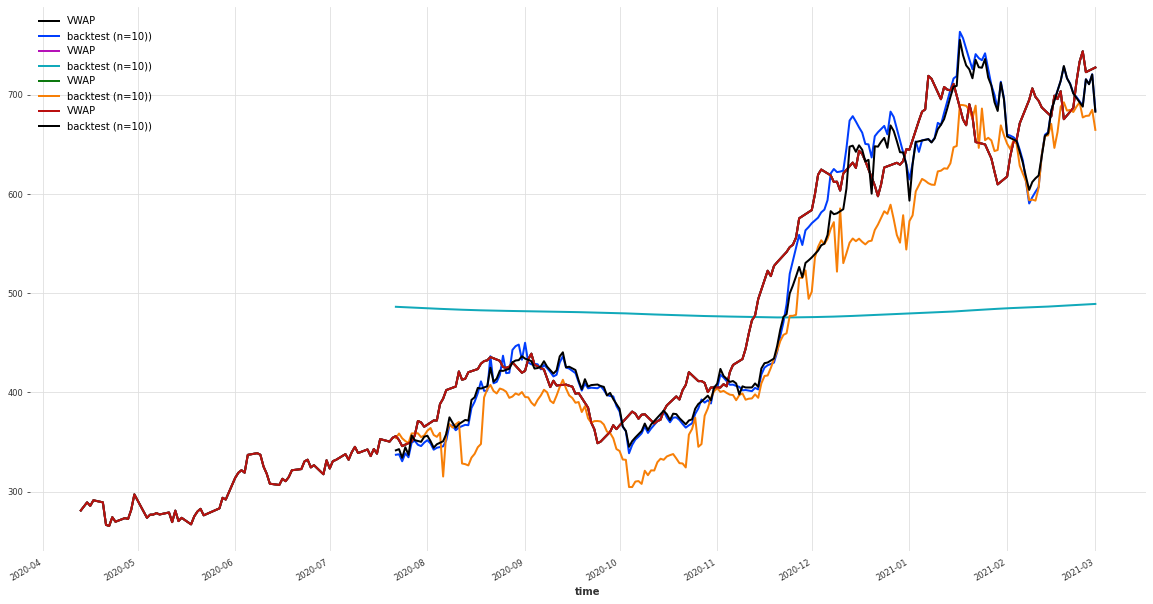

In [126]:
result = [eval_model(m, train_ds, retrain=True) for m in models]

In [142]:
preds = np.vstack([r.values().reshape(-1) for r in result]).T

<AxesSubplot:>

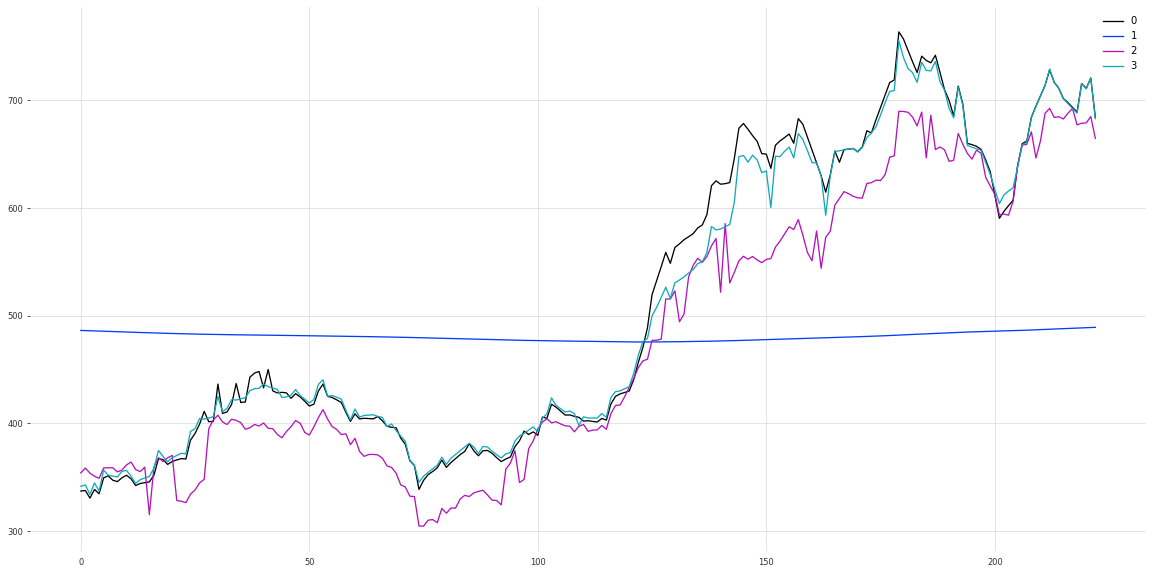

In [161]:
pd.DataFrame(preds).plot()